For running install the necessary packages and include the package folders VeloVAE and NewVeloVAE in the same folder as this notebook

In [1]:
import anndata
import dynamo as dyn
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scvelo as scv
import scanpy as sc
from scipy.sparse import csr_matrix
import seaborn as sns
import SEACells
from sklearn.decomposition import PCA
import sys
import torch
from umap import UMAP

sys.path.append('./NewVeloVAE')
sys.path.append('./VeloVAE')
import newvelovae as nvv
import velovae as vv

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/bernaljp/miniconda3/envs/projectDM/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
%matplotlib inline

In [3]:
n_jobs=48

# Load Input Data
We demonstrate the full training pipeline using an example dataset from scVelo.

In [4]:
dataset = "Pancreas"
adata = scv.datasets.pancreas()

Set the parent folder names for saving model parameters, data and figures.

In [5]:
model_path_base = f"checkpoints/Checkpoint2/{dataset}"
figure_path_base = f"figures/Checkpoint2/{dataset}"
data_path_base = f"data/Checkpoint2/{dataset}"

# Metacells
Obtaining the metacells using SEACells

In [6]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_umap' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [7]:
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells,
                  #use_gpu = True, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [8]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3696 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/3696 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3696 [00:00<?, ?it/s]

Constructing CSR matrix...


In [9]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_umap
Computing diffusion components from X_umap for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 82 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 18/18 [00:00<00:00, 793.32it/s]

Selecting 8 cells from greedy initialization.


In [10]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00113
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 47 iterations.


<br><br><br><br><br>
# Preprocessing
We apply exactly the same preprocessing steps as scVelo.
The "preprocess" function performs the following:
1. Cell and gene filtering based on mRNA counts.<br><br>
2. Select a number of genes. By default, it applies the selection method in scVelo to pick highly variable genes. The user can also choose to pick a balanced set of genes by setting <b>"selection_method"</b> to "balanced", meaning that all cell types have the same number of marker genes. Besides these two options, the user can also input a custom list of genes via the argument <b>"genes_retain"</b>.<br><br>
3. Compute a KNN graph based on PCA and average the count data across k neighbors. Dimension of PCA can be set via the argument <b>"npc"</b>. The user can also set the number of neighbors via <b>"n_neighbors"</b>.<br><br>
4. Optionally performs clustering when <b>"perform_clustering"</b> is set to "True".<br><br>
5. Optionally add informative time prior if <b>"tkey"</b> is set to the key in .obs that contains the capture time (either string or float).<br><br>
5. Optionally computes 2D UMAP embedding when <b>"compute_umap"</b> is set to "True".
6. Compute the counts matrices for the metacells

In [11]:
Ngene = 2000
vv.preprocess(adata, Ngene, method='sklearn')

Filtered out 21061 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.


In [ ]:
SEACell_ad = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='Ms')
SEACell_ad.layers['Ms'] = SEACell_ad.layers['raw']
SEACell_ad.layers['Mu'] = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='Mu').layers['raw']
SEACell_ad.layers['spliced'] = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='spliced').layers['raw']
SEACell_ad.layers['unspliced'] = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='unspliced').layers['raw']

SEACell_ad.layers['Ms'] = SEACell_ad.layers['Ms'].A
SEACell_ad.layers['Mu'] = SEACell_ad.layers['Mu'].A
SEACell_ad.layers['spliced'] = SEACell_ad.layers['spliced'].A
SEACell_ad.layers['unspliced'] = SEACell_ad.layers['unspliced'].A

del SEACell_ad.layers['raw']
SEACell_ad

100%|██████████| 90/90 [00:00<00:00, 222.88it/s]


AnnData object with n_obs × n_vars = 90 × 2000
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'

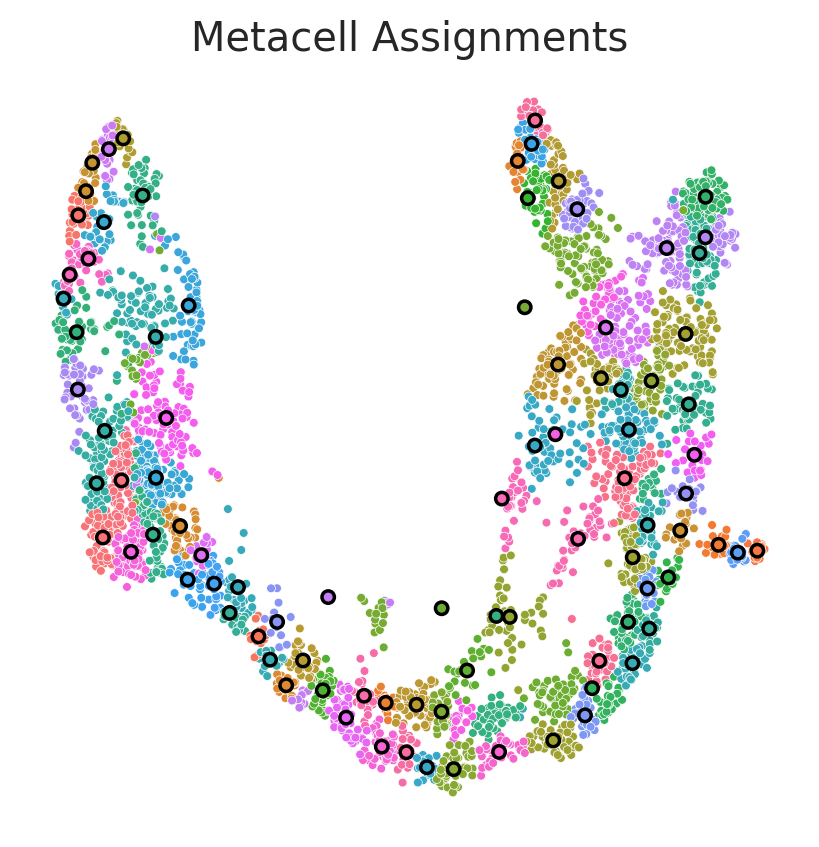

In [ ]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=True)

Pick some genes to plot.

In [12]:
gene_plot = ["Gng12", "Smoc1"]

# Run scVelo
Overview of the dataset on UMAP

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


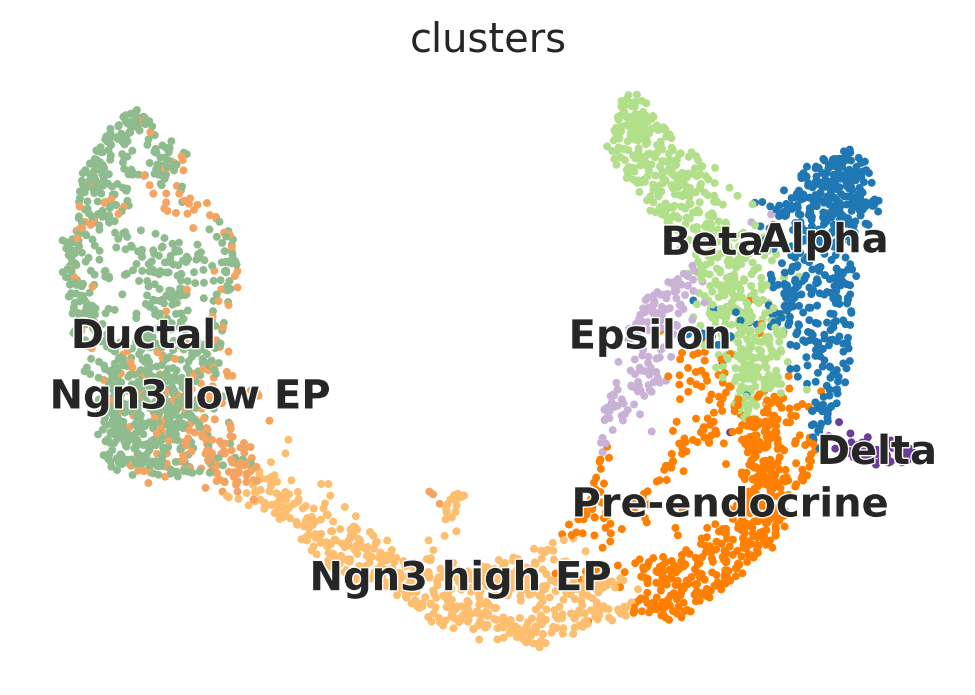

In [14]:
os.makedirs(figure_path_base, exist_ok=True)
scv.pl.scatter(adata, basis='umap')#, save=figure_path_base+"/umap.png")

Run scVelo and compute the velocity and latent time

In [15]:
scv.tl.recover_dynamics(adata,n_jobs=n_jobs)
scv.tl.velocity(adata, vkey='velocity', mode='dynamical')
scv.tl.latent_time(adata)

recovering dynamics (using 48/48 cores)


  0%|          | 0/1263 [00:00<?, ?gene/s]

    finished (0:02:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


In [27]:
vae.save_model(model_path, "encoder","decoder")
vae.save_anndata(adata, 'vae', data_path, file_name="pancreas_out.h5ad")

# mvae.save_model(model_path_meta, "encoder_meta","decoder_meta")
# mvae.save_anndata(adata, SEACell_ad, 'meta_vae', data_path, file_name="pancreas_out.h5ad")

dvae.save_model(model_path_dependent, "encoder_dependent","decoder_dependent")
dvae.save_anndata(adata, SEACell_ad, 'dependent_vae', data_path, file_name="pancreas_out.h5ad")

# Train Full VeloVAE model

<br><br><br><br><br>
# Train a Full VeloVAE Model
***
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [21]:
# figure_path_meta = figure_path_base+"/MetaVAE"
# model_path_meta = model_path_base+"/MetaVAE"
figure_path_dependent = figure_path_base+"/DependentFullVAE"
model_path_dependent = model_path_base+"/DependentFullVAE"
figure_path = figure_path_base+"/FullVAE"
model_path = model_path_base+"/FullVAE"
data_path = data_path_base

## Step 2: Create a VAE object
Mandatory Arguments:
1. <b>adata</b>: anndata object<br><br>
2. <b>tmax</b>: time range. We set it to 20 following the convention from scVelo.<br><br>

Critical Arguments:
1. <b>device</b>: please set to the corresponding cuda device for training if possible.<br><br>
2. <b>hidden_size</b>: a tuple, e.g. (500,250). The two numbers are width of the first and second hidden layers of the encoder network.<br><br>
3. <b>init_method</b>: rate parameter initialization method. By default, the parameter is set to "steady", meaning the steady state model. However, if capture time is available, please consider setting it to "tprior", and the model will be initialized from a time series where the time is approximated by the capture time.<br><br>
4. <b>init_key</b>: key in .obs storing the informative time prior. This is effective only if init_method is set to "tprior".<br><br>
5. <b>tprior</b>: key in .obs storing the informative time prior. <b>This is usually the same key as "init_key", but has a different purpose. This key is used when we compute the KL divergence in ELBO, while "init_key" is used only in initialization.</b>

In [ ]:
torch.manual_seed(2022)
np.random.seed(2022)

# mvae = mvv.VAE(adata, SEACell_ad, tmax=20, dim_z=5, device='cuda:0')
full_vae = vv.VAE(adata, tmax=20, dim_z=5, device='cuda:0', full_vb=True)
full_dvae = nvv.VAE(adata, tmax=20, dim_z1=10, dim_z=5, device='cuda:0', full_vb=True)

## Step 3: Mini-batch training
Mandatory Arguments:
1. <b>adata</b>: anndata object
***
Critical Arguments:
1. <b>config</b>: a dictionary containing all hyperparameters. The keys are parameter names (string). Most default hyperparameters achieved consistent performance across different datasets. However, we recommend modifying the following hyperparameters in certain situations:<br><br>
(1) <b>batch_size</b>: set to 128 by default. However, for large datasets, we recommend increasing the batch size accordingly.<br><br>
(2) <b>early_stop</b>: set to 5 by default. This is the number of consecutive epochs when the validation loss decreases by less than some threshold (introduced in the next item), used in early stopping. <br><br>
(3) <b>early_stop_thred</b>: set to $n_{gene}\cdot 10^{-3}$ by default. This is the threshold used in early stopping.<br>

"config" will not be required if you just want the default, as shown in the following line of code.

### Train MetaVeloVAE
Extra mandatory Arguments:
1. <b>meta_adata</b>: anndata object for the metacells

In [23]:
full_dvae.train(adata, SEACell_ad, plot=True, gene_plot=gene_plot, figure_path=figure_path_dependent)

Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -30176.846,	Test ELBO = -544939.317,	Total Time =   0 h :  0 m :  6 s
Epoch 100: Train ELBO = -4343.912,	Test ELBO = -4427.800,	Total Time =   0 h :  1 m :  9 s
Epoch 200: Train ELBO = -2712.003,	Test ELBO = -2827.718,	Total Time =   0 h :  2 m : 13 s
Epoch 300: Train ELBO = -1027.916,	Test ELBO = -1068.488,	Total Time =   0 h :  3 m : 21 s
Epoch 400: Train ELBO = 5

  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 74


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


Epoch 1042: Train ELBO = 3296.665,	Test ELBO = 3216.103,	Total Time =   0 h : 11 m : 20 s
Epoch 1100: Train ELBO = 3502.602,	Test ELBO = 3426.768,	Total Time =   0 h : 12 m :  2 s
Epoch 1200: Train ELBO = 3617.567,	Test ELBO = 3543.027,	Total Time =   0 h : 13 m :  6 s
*********     Round 1: Early Stop Triggered at epoch 1207.    *********
Change in noise variance: 0.4561
*********             Velocity Refinement Round 2             *********
Epoch 1208: Train ELBO = 3441.468,	Test ELBO = 3381.097,	Total Time =   0 h : 13 m : 18 s
*********     Round 2: Early Stop Triggered at epoch 1261.    *********
Change in noise variance: 0.0034
Change in x0: 0.3879
*********             Velocity Refinement Round 3             *********
Epoch 1262: Train ELBO = 3365.915,	Test ELBO = 3298.337,	Total Time =   0 h : 13 m : 57 s
*********     Round 3: Early Stop Triggered at epoch 1282.    *********
Change in noise variance: 0.0022
Change in x0: 0.3759
*********             Velocity Refinement Round 4

### Train VeloVAE

In [24]:
full_vae.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path)

Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -13763.763,	Test ELBO = -338869.285,	Total Time =   0 h :  0 m :  5 s
Epoch 100: Train ELBO = 1429.704,	Test ELBO = 1411.106,	Total Time =   0 h :  0 m : 47 s
Epoch 200: Train ELBO = 1945.728,	Test ELBO = 1907.867,	Total Time =   0 h :  1 m : 32 s
Epoch 300: Train ELBO = 2059.993,	Test ELBO = 2021.244,	Total Time =   0 h :  2 m : 17 s
*********       Stage 1: Early 

  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.028
Average Set Size: 74
Epoch 358: Train ELBO = 3583.171,	Test ELBO = 3227.625,	Total Time =   0 h :  2 m : 52 s
Epoch 400: Train ELBO = 4631.916,	Test ELBO = 4566.912,	Total Time =   0 h :  3 m : 15 s
Epoch 500: Train ELBO = 4793.340,	Test ELBO = 4726.813,	Total Time =   0 h :  3 m : 58 s
*********     Round 1: Early Stop Triggered at epoch 559.    *********
Change in noise variance: 0.5267
*********             Velocity Refinement Round 2             *********
Epoch 560: Train ELBO = 4634.667,	Test ELBO = 4526.875,	Total Time =   0 h :  4 m : 31 s
Epoch 600: Train ELBO = 4719.285,	Test ELBO = 4649.105,	Total Time =   0 h :  4 m : 56 s
Epoch 700: Train ELBO = 4797.097,	Test ELBO = 4721.843,	Total Time =   0 h :  5 m : 45 s
*********     Round 2: Early Stop Triggered at epoch 702.    *********
Change in noise variance: 0.0024
Change in x0: 0.3010
*********             Velocity Refinement Round 3             *********
Epoch 703: Train ELBO = 4714.938,	Test

## Step 4: Save results

In [25]:
full_vae.save_model(model_path, "encoder","decoder")
full_vae.save_anndata(adata, 'full_vae', data_path, file_name="pancreas_out.h5ad")

# mvae.save_model(model_path_meta, "encoder_meta","decoder_meta")
# mvae.save_anndata(adata, SEACell_ad, 'meta_vae', data_path, file_name="pancreas_out.h5ad")

full_dvae.save_model(model_path_dependent, "encoder_dependent_full","decoder_dependent_full")
full_dvae.save_anndata(adata, SEACell_ad, 'dependent_full_vae', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Post Analysis
## Compute the Metrics and Plot the Genes
Use the built-in analysis function of the velovae package
***
Mandatory Arguments:
1. <b>adata</b>: anndata object<br><br>
2. <b>test_id</b>: name of the test. Used for storing the figures.<br><br>
3. <b>methods</b>: name of the methods. Should be a list containing one or multiple of the following: "scVelo", "Vanilla VAE", "VeloVAE", "Full VB".<br><br>
4. <b>keys</b>: list of key names corresponding to each method. This is used to extract all relevant quantities (latent variables, rate parameters). For example, when we pick VeloVAE as the method, the corresponding key is "vae". The rate parameters were previously stored as "vae_alpha", "vae_beta", "vae_gamma" in .var when we called the 'save_anndata' function. 
***
Critical Arguments:
1. <b>compute_metrics</b>: whether to compute the performance metrics. Should be set to False if you only want figures.<br><br>
2. <b>genes</b>: genes to plot.<br><br>
3. <b>plot_type</b>: list of plot type names. Should contain zero or more from the following: "phase", "signal", "time", "cluster".<br><br>
4. <b>grid_size</b>: tuple, e.g. (M,N). The signal plot of genes will be in a single figure containing a grid of subplots. The grid has M rows and N columns. If $M\times N<n_{gene}$, multiple figures will be generated.

In [33]:
vv.scvelo_preprocessing.moments(adata,method='sklearn',n_pcs=30)

Normalized count data: spliced, unspliced.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Cluster scores

In [36]:
methods = ['VeloVAE','VeloVAE']
keys = ['full_vae','dependent_full_vae']
grid_size = (1,2)
plot_type = ["phase","signal","time"]
vv.post_analysis(adata, 
                 test_id="pancreas",
                 methods=methods, 
                 keys=keys,
                 compute_metrics=True,
                 genes=gene_plot, 
                 plot_type=plot_type, 
                 embed="umap", 
                 grid_size=grid_size, 
                 save_path=figure_path_base,
                 cluster_key='clusters',
                 n_jobs=n_jobs)

Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:25) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


---     Computing Peformance Metrics     ---
Dataset Size: 3696 cells, 2000 genes
---   Plotting  Results   ---


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.


(                                VeloVAE  VeloVAE (dependent_full_vae)
 MSE Train                         0.277                         3.234
 MSE Test                          0.267                         3.230
 MAE Train                         0.184                         0.334
 MAE Test                          0.183                         0.327
 LL Train                       2284.383                      1323.490
 LL Test                        2279.609                      1350.111
 Training Time                   468.121                       877.938
 corr                                NaN                           NaN
 CBDir (Embed, Subset)               NaN                           NaN
 CBDir (Subset)                      NaN                           NaN
 In-Cluster Coherence (Subset)     0.932                         0.972
 Vel Consistency (Subset)          0.928                         0.972
 CBDir (Embed)                       NaN                           NaN
 CBDir

### Cluster edges

In [37]:
cluster_edges = [('Ductal','Ngn3 low EP'),
                 ('Ngn3 low EP','Ngn3 high EP'),
                 ('Ngn3 high EP','Pre-endocrine'),
                 ('Pre-endocrine','Alpha'),
                 ('Pre-endocrine','Beta'),
                 ('Pre-endocrine','Delta'),
                 ('Pre-endocrine','Epsilon')]

In [38]:
methods = ['VeloVAE','VeloVAE']
keys = ['full_vae','dependent_full_vae']
grid_size = (1,2)
plot_type = ["phase","signal","time"]
st,stt = vv.post_analysis(adata, 
                 test_id="pancreas",
                 methods=methods, 
                 keys=keys,
                 compute_metrics=True,
                 genes=gene_plot, 
                 plot_type=plot_type, 
                 embed="umap", 
                 grid_size=grid_size, 
                 figure_path=figure_path_base,
                 cluster_key='clusters',
                 cluster_edges=cluster_edges,
                 n_jobs=n_jobs)

Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 3696 cells, 2000 genes
---   Plotting  Results   ---
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.


In [39]:
st.dropna()

,VeloVAE,VeloVAE (dependent_full_vae)
MSE Train,0.277,3.234
MSE Test,0.267,3.230
MAE Train,0.184,0.334
MAE Test,0.183,0.327
LL Train,2284.383,1323.490
LL Test,2279.609,1350.111
Training Time,468.121,877.938
"CBDir (Embed, Subset)",0.423,0.344
CBDir (Subset),0.213,0.144
In-Cluster Coherence (Subset),0.932,0.972


In [41]:
print('Full VAE')
stt['VeloVAE'].iloc[:,7:14]

Dependent VAE


,"(Ductal, Ngn3 low EP)","(Ngn3 low EP, Ngn3 high EP)","(Ngn3 high EP, Pre-endocrine)","(Pre-endocrine, Alpha)","(Pre-endocrine, Beta)","(Pre-endocrine, Delta)","(Pre-endocrine, Epsilon)"
CBDir (Subset),0.079,0.268,0.085,0.167,0.206,0.165,0.040
"CBDir (Embed, Subset)",0.226,0.791,0.427,0.519,0.563,-0.216,0.098
CBDir,0.080,0.135,0.103,0.054,0.060,0.009,0.009
CBDir (Embed),0.238,0.812,0.520,0.501,0.559,-0.215,0.151
Time Score,0.581,0.893,0.742,0.799,0.804,0.250,0.774


In [ ]:
print('Full Modified VAE')
stt['VeloVAE'].iloc[:,14:21]

Full VAE


,"(Ductal, Ngn3 low EP)","(Ngn3 low EP, Ngn3 high EP)","(Ngn3 high EP, Pre-endocrine)","(Pre-endocrine, Alpha)","(Pre-endocrine, Beta)","(Pre-endocrine, Delta)","(Pre-endocrine, Epsilon)"
CBDir (Subset),0.182,0.299,0.378,0.160,0.038,0.252,0.282
"CBDir (Embed, Subset)",0.502,0.676,0.635,0.315,0.014,0.493,0.478
CBDir,0.157,0.232,0.238,0.117,0.020,0.420,0.316
CBDir (Embed),0.476,0.677,0.608,0.226,0.045,0.451,0.498
Time Score,0.563,0.890,0.765,0.589,0.487,0.926,0.875


## Cell Time and State Uncertainty
We can call plot_state_var and plot_time_var directly from the velovae.plotting module.

In [ ]:
basis = "umap"

## Plotting satate variables

### VAE original

In [ ]:
key = 'full_vae'
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Checkpoint2/Pancreas/pancreas_full_vae_state_var.png")

### Modfied VAE

In [ ]:
key = 'dependent_full_vae'
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Checkpoint2/Pancreas/pancreas_dependent_full_vae_state_var.png")

std_z = adata.obsm[f"{key}_std_z1"]
z = adata.obsm[f"{key}_z1"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/NewTests/Pancreas/pancreas_dependent_full_vae_state_var1.png")

### Time

In [ ]:
t = adata.obs["full_vae_time"].to_numpy()
std_t = adata.obs["full_vae_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=f"figures/NewTests/Pancreas/pancreas_full_vae_time_var.png")

t = adata.obs["dependent_full_vae_time"].to_numpy()
std_t = adata.obs["dependent_full_vae_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=f"figures/NewTests/Pancreas/pancreas_dependent_full_vae_time_var.png")

## Other Results

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

key = "full_vae"
t3 = adata.obs[f'{key}_time'].to_numpy()
rho3 = adata.layers[f'{key}_rho']

key = "dependent_full_vae"
t4 = adata.obs[f'{key}_time'].to_numpy()
rho4 = adata.layers[f'{key}_rho']

cell_labels = adata.obs['clusters'].to_numpy()
cell_types = np.unique(cell_labels)
colors = vv.plotting.get_colors(len(cell_types))

## Result 1: Transcription Rate $\rho$

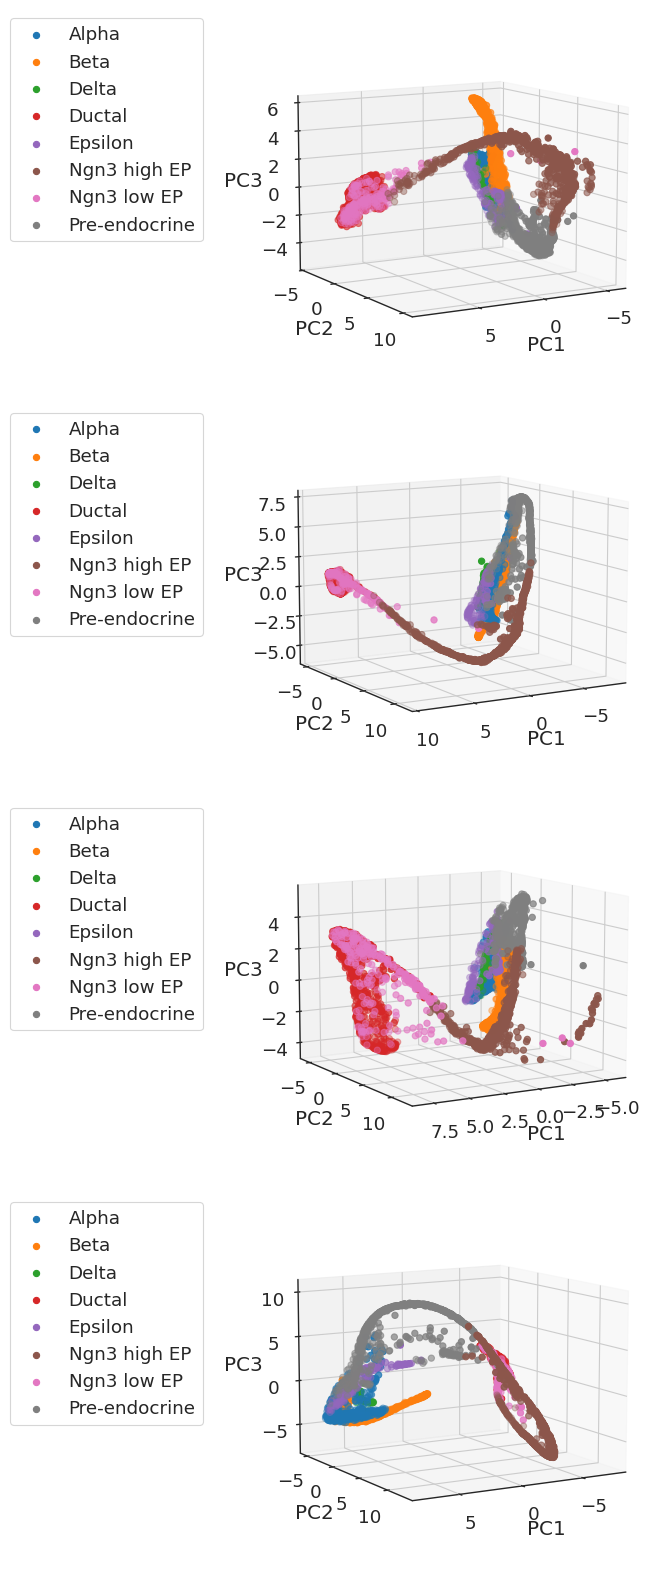

In [ ]:
pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho1)

fig=plt.figure(figsize=(10,16))

ax = fig.add_subplot(4,1,1,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho2)

ax = fig.add_subplot(4,1,2,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho3)
ax = fig.add_subplot(4,1,3,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho4)

ax = fig.add_subplot(4,1,4,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

plt.tight_layout()
plt.show()

fig.savefig(figure_path_base+'/rho_pca.png')

## Result 2: Latent Embedding

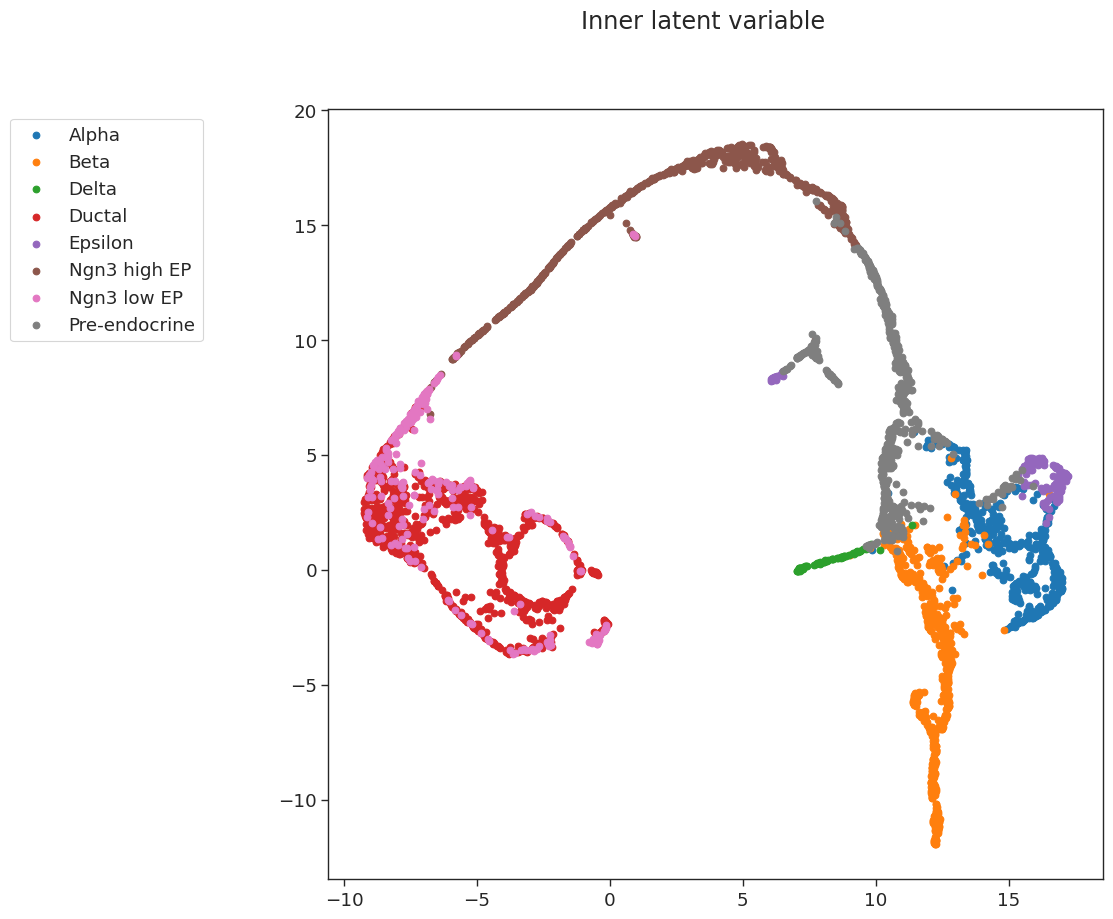

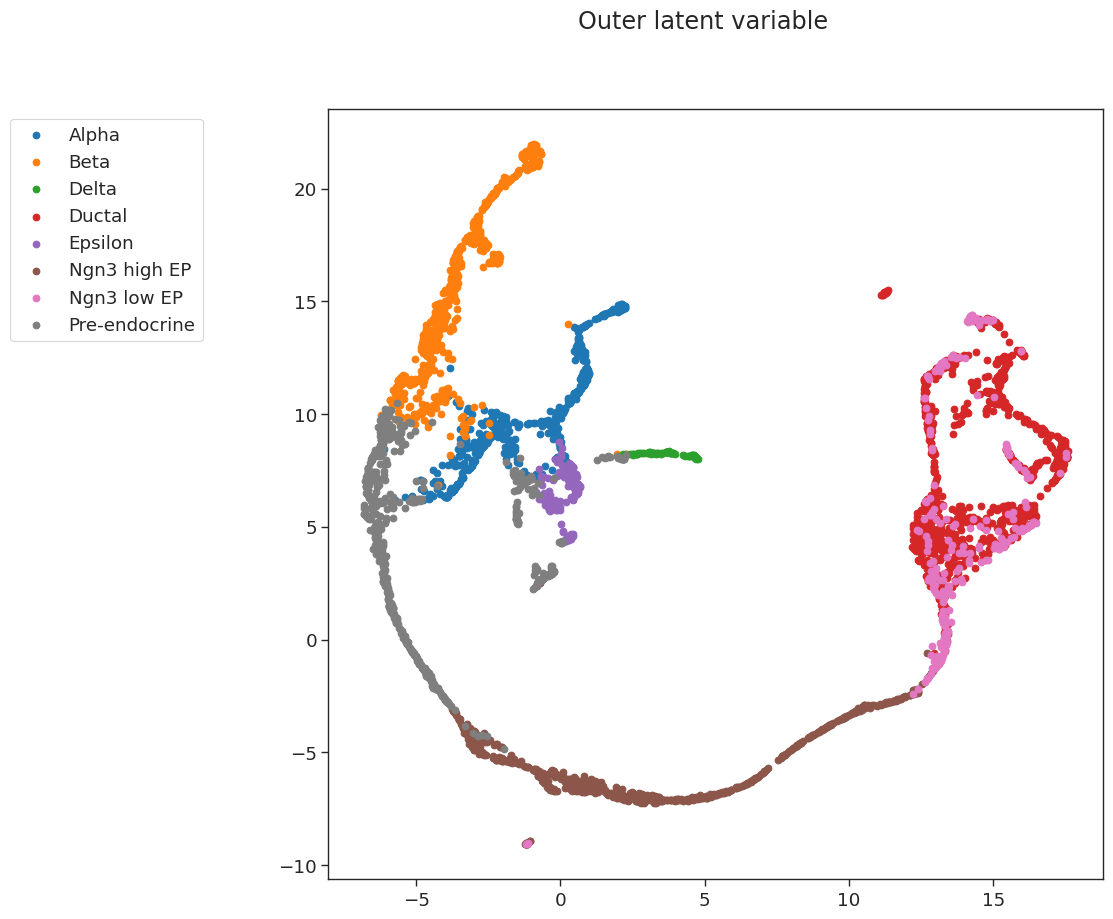

In [ ]:
key = 'dependent_full_vae'

z = adata.obsm[f"{key}_z"]
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
fig.suptitle("Inner latent variable")
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path_base+'/dependent_full_vae_z_umap.png')

z = adata.obsm[f"{key}_z1"]
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
fig.suptitle("Outer latent variable")
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

plt.show()
fig.savefig(figure_path_base+'/dependent_full_vae_z1_umap.png')

## Result 3: Velocity Stream Plot

computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:30) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Checkpoint2/Pancreas/Pancreas_velocity_scv.png


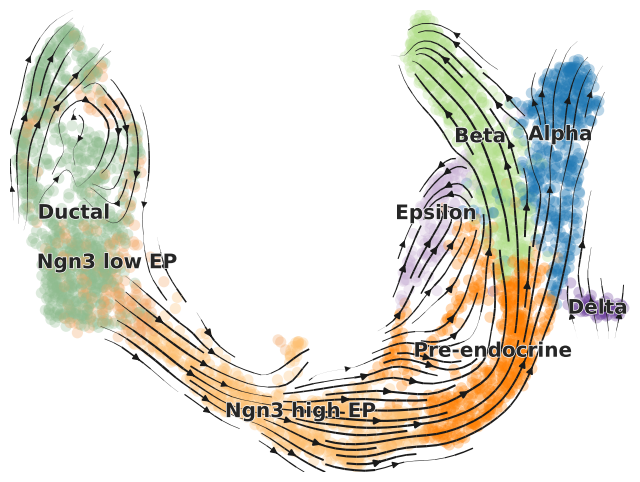

In [ ]:
import scvelo as scv
scv.tl.velocity_graph(adata, vkey='velocity',n_jobs=n_jobs)
scv.tl.velocity_embedding(adata, vkey='velocity')
scv.pl.velocity_embedding_stream(adata, vkey='velocity', figsize=(8,6), title="", save=f'{figure_path_base}/{dataset}_velocity_scv.png')

computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Checkpoint2/Pancreas/Pancreas_velocity_full_vae.png


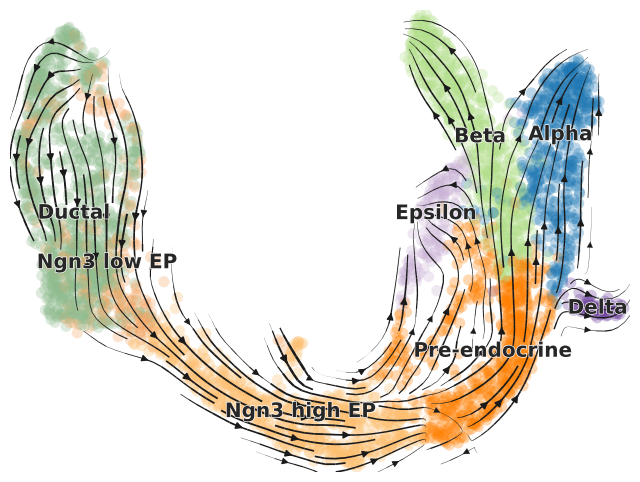

In [ ]:
key = 'full_vae'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity',n_jobs=n_jobs)
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

computing velocities
    finished (0:00:01) --> added 
    'full_dependent_vae_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 48/48 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'full_dependent_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'full_dependent_vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Checkpoint2/Pancreas/Pancreas_velocity_full_dependent_vae.png


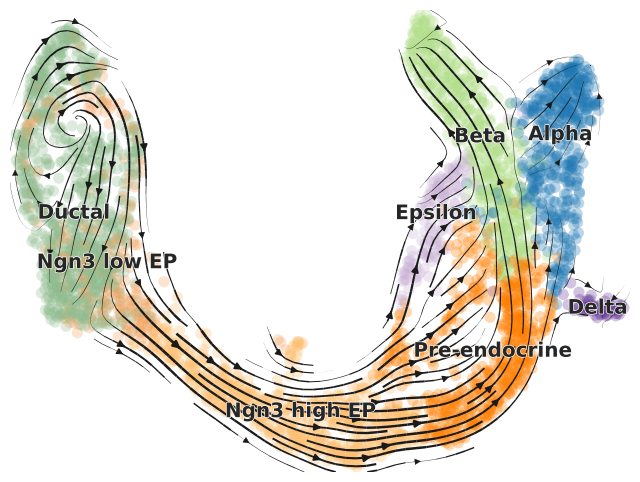

In [ ]:
key = 'full_dependent_vae'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity',n_jobs=n_jobs)
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

In [ ]:
adata.write_h5ad(data_path_base+"/pancreas_out.h5ad")

# Generation

## From datapoints

In [26]:
def sample_model(model, adata, meta_adata, n_samples=1000, sample_meta=False):

    sample_idx = np.random.permutation(adata.n_obs)[:n_samples] if n_samples is not None else range(adata.n_obs)
    spliced_samples = torch.tensor(adata.layers['Ms'][sample_idx,:], dtype=torch.float32)
    unspliced_samples = torch.tensor(adata.layers['Mu'][sample_idx,:], dtype=torch.float32)
    meta_idx = adata.obs['SEACell'][sample_idx].str.extract(r'(\d+)').astype(int).values.flatten() if n_samples is not None else sample_idx
    spliced_meta_samples = torch.tensor(meta_adata.layers['Ms'][meta_idx,:], dtype=torch.float32)
    unspliced_meta_samples = torch.tensor(meta_adata.layers['Mu'][meta_idx,:], dtype=torch.float32)
    
    n_samples = n_samples if n_samples is not None else adata.n_obs

    data = torch.concat((unspliced_samples, spliced_samples),axis=1)
    meta_data = torch.concat((unspliced_meta_samples, spliced_meta_samples),axis=1)

    data_in_scale = data.to(model.device)
    meta_data = meta_data.to(model.device) if not sample_meta else data_in_scale
    
    u0 = torch.tensor(model.u0, device=model.device)[sample_idx] if not sample_meta else None
    s0 = torch.tensor(model.s0, device=model.device)[sample_idx] if not sample_meta else None
    t0 = torch.tensor(model.t0, device=model.device)[sample_idx] if not sample_meta else None

    _, _, _, _, t1, zz1, uhat1, shat1, _, _, vu1, vs1, _, _, z1, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)
    _, _, _, _, t2, zz2, uhat2, shat2, _, _, vu2, vs2, _, _, z2, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)
    _, _, _, _, t3, zz3, uhat3, shat3, _, _, vu3, vs3, _, _, z3, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)
    _, _, _, _, t4, zz4, uhat4, shat4, _, _, vu4, vs4, _, _, z4, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)

    if u0 is None:
        uhat1, shat1, vu1, vs1 = uhat1[:,0,:], shat1[:,0,:], vu1[:,0,:], vs1[:,0,:]
        uhat2, shat2, vu2, vs2 = uhat2[:,0,:], shat2[:,0,:], vu2[:,0,:], vs2[:,0,:]
        uhat3, shat3, vu3, vs3 = uhat3[:,0,:], shat3[:,0,:], vu3[:,0,:], vs3[:,0,:]
        uhat4, shat4, vu4, vs4 = uhat4[:,0,:], shat4[:,0,:], vu4[:,0,:], vs4[:,0,:]
    
    sample_adata = anndata.AnnData(csr_matrix(np.zeros((4*n_samples,adata.n_vars))))
    sample_adata.var = adata.var
    sample_adata.layers['Ms'] = np.vstack((shat1.detach().cpu().numpy(),shat2.detach().cpu().numpy(),shat3.detach().cpu().numpy(),shat4.detach().cpu().numpy()))
    sample_adata.layers['Mu'] = np.vstack((uhat1.detach().cpu().numpy(),uhat2.detach().cpu().numpy(),uhat3.detach().cpu().numpy(),uhat4.detach().cpu().numpy()))
    sample_adata.layers['velocity'] = np.vstack((vs1.detach().cpu().numpy(),vs2.detach().cpu().numpy(),vs3.detach().cpu().numpy(),vs4.detach().cpu().numpy()))
    sample_adata.layers['velocity_u'] = np.vstack((vu1.detach().cpu().numpy(),vu2.detach().cpu().numpy(),vu3.detach().cpu().numpy(),vu4.detach().cpu().numpy()))
    sample_adata.obs['latent_time'] = torch.concat((t1,t2,t3,t4)).detach().cpu().numpy()
    sample_adata.obs['original_index'] = np.tile(sample_idx,4)
    sample_adata.obsm['outer_latent'] = np.vstack((z1.detach().cpu().numpy(),z2.detach().cpu().numpy(),z3.detach().cpu().numpy(),z4.detach().cpu().numpy()))
    sample_adata.obsm['inner_latent'] = np.vstack((zz1.detach().cpu().numpy(),zz2.detach().cpu().numpy(),zz3.detach().cpu().numpy(),zz4.detach().cpu().numpy()))
    
    if not sample_meta:
        sample_adata.obs['original_clusters'] = np.tile(adata.obs['clusters'][sample_idx].values,4)

    return sample_adata


In [27]:
def sample_original_model(model, adata, n_samples=1000, sample_meta=False):

    sample_idx = np.random.permutation(adata.n_obs)[:n_samples] if n_samples is not None else range(adata.n_obs)
    spliced_samples = torch.tensor(adata.layers['Ms'][sample_idx,:], dtype=torch.float32)
    unspliced_samples = torch.tensor(adata.layers['Mu'][sample_idx,:], dtype=torch.float32)
    
    n_samples = n_samples if n_samples is not None else adata.n_obs

    data = torch.concat((unspliced_samples,spliced_samples),axis=1)

    data_in_scale = data.to(model.device)
    
    u0 = torch.tensor(model.u0, device=model.device)[sample_idx] if not sample_meta else None
    s0 = torch.tensor(model.s0, device=model.device)[sample_idx] if not sample_meta else None
    t0 = torch.tensor(model.t0, device=model.device)[sample_idx] if not sample_meta else None

    _, _, _, _, t1, z1, uhat1, shat1, _, _, vu1, vs1, _, _ = model.forward(data_in_scale,u0,s0,t0)
    _, _, _, _, t2, z2, uhat2, shat2, _, _, vu2, vs2, _, _ = model.forward(data_in_scale,u0,s0,t0)
    _, _, _, _, t3, z3, uhat3, shat3, _, _, vu3, vs3, _, _ = model.forward(data_in_scale,u0,s0,t0)
    _, _, _, _, t4, z4, uhat4, shat4, _, _, vu4, vs4, _, _ = model.forward(data_in_scale,u0,s0,t0)
    
    if u0 is None:
        uhat1, shat1, vu1, vs1 = uhat1[:,0,:], shat1[:,0,:], vu1[:,0,:], vs1[:,0,:]
        uhat2, shat2, vu2, vs2 = uhat2[:,0,:], shat2[:,0,:], vu2[:,0,:], vs2[:,0,:]
        uhat3, shat3, vu3, vs3 = uhat3[:,0,:], shat3[:,0,:], vu3[:,0,:], vs3[:,0,:]
        uhat4, shat4, vu4, vs4 = uhat4[:,0,:], shat4[:,0,:], vu4[:,0,:], vs4[:,0,:]
    
    sample_adata = anndata.AnnData(csr_matrix(np.zeros((4*n_samples,adata.n_vars))))
    sample_adata.var = adata.var
    sample_adata.layers['Ms'] = np.vstack((shat1.detach().cpu().numpy(),shat2.detach().cpu().numpy(),shat3.detach().cpu().numpy(),shat4.detach().cpu().numpy()))
    sample_adata.layers['Mu'] = np.vstack((uhat1.detach().cpu().numpy(),uhat2.detach().cpu().numpy(),uhat3.detach().cpu().numpy(),uhat4.detach().cpu().numpy()))
    sample_adata.layers['velocity'] = np.vstack((vs1.detach().cpu().numpy(),vs2.detach().cpu().numpy(),vs3.detach().cpu().numpy(),vs4.detach().cpu().numpy()))
    sample_adata.layers['velocity_u'] = np.vstack((vu1.detach().cpu().numpy(),vu2.detach().cpu().numpy(),vu3.detach().cpu().numpy(),vu4.detach().cpu().numpy()))
    sample_adata.obs['latent_time'] = torch.concat((t1,t2,t3,t4)).detach().cpu().numpy()
    sample_adata.obs['original_index'] = np.tile(sample_idx,4)
    sample_adata.obsm['latent'] = np.vstack((z1.detach().cpu().numpy(),z2.detach().cpu().numpy(),z3.detach().cpu().numpy(),z4.detach().cpu().numpy()))
    
    if not sample_meta:
        sample_adata.obs['original_clusters'] = np.tile(adata.obs['clusters'][sample_idx].values,4)

    return sample_adata


In [39]:
sample_meta_adata = sample_model(full_dvae, adata, SEACell_ad, n_samples=1000)
sample_adata = sample_original_model(full_vae, adata, n_samples=1000)

In [40]:
ump = UMAP(n_components=2)
cells_2d = ump.fit_transform(adata.layers['Ms'])

In [41]:
sample_meta_2d = ump.transform(sample_meta_adata.layers['Ms'])
sample_2d = ump.transform(sample_adata.layers['Ms'])

Text(0.5, 1.0, 'VAE + Metacells: Data vs. Sample')

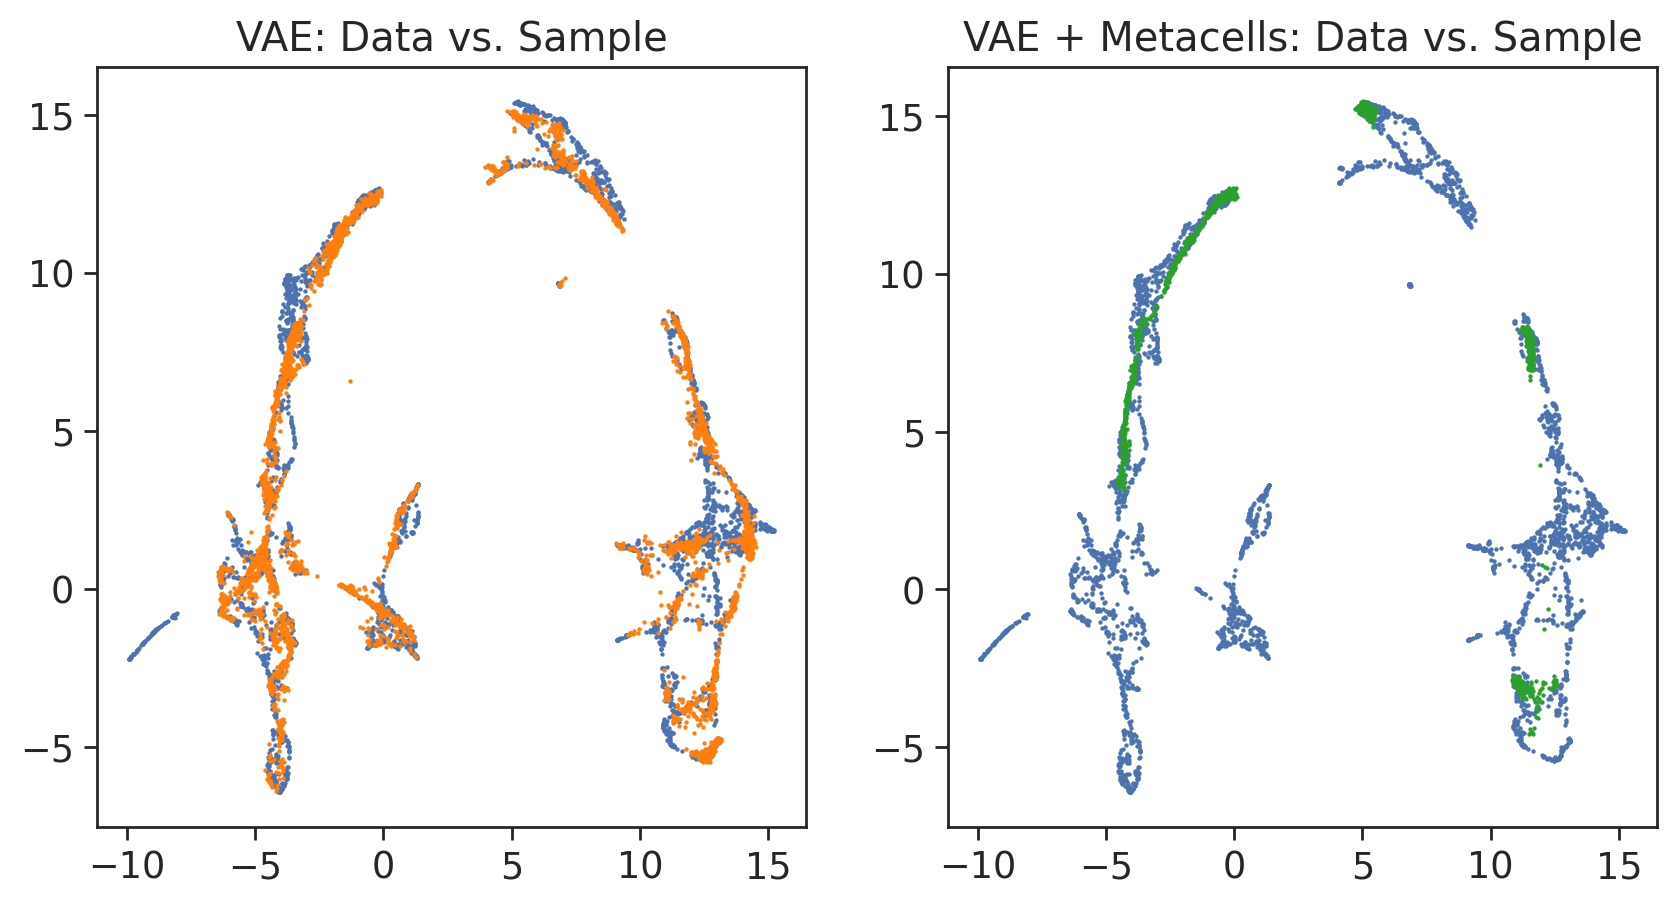

In [42]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_2d.T, s=0.6, c='tab:orange')
ax.set_title('VAE: Data vs. Sample')

ax = plt.subplot(1,2,2)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_meta_2d.T, s=0.6, c='tab:green')
ax.set_title('VAE + Metacells: Data vs. Sample')

## From Metacells

In [32]:
sample_meta_metaadata = sample_model(full_dvae, SEACell_ad, SEACell_ad, None, sample_meta=True)
sample_metaadata = sample_original_model(full_vae, SEACell_ad, None, sample_meta=True)

In [33]:
sample_metameta_2d = ump.transform(sample_meta_metaadata.layers['Ms'])
sample_metaoriginal_2d = ump.transform(sample_metaadata.layers['Ms'])

Text(0.5, 1.0, 'VAE + Metacells: Data vs. Metacells Sample')

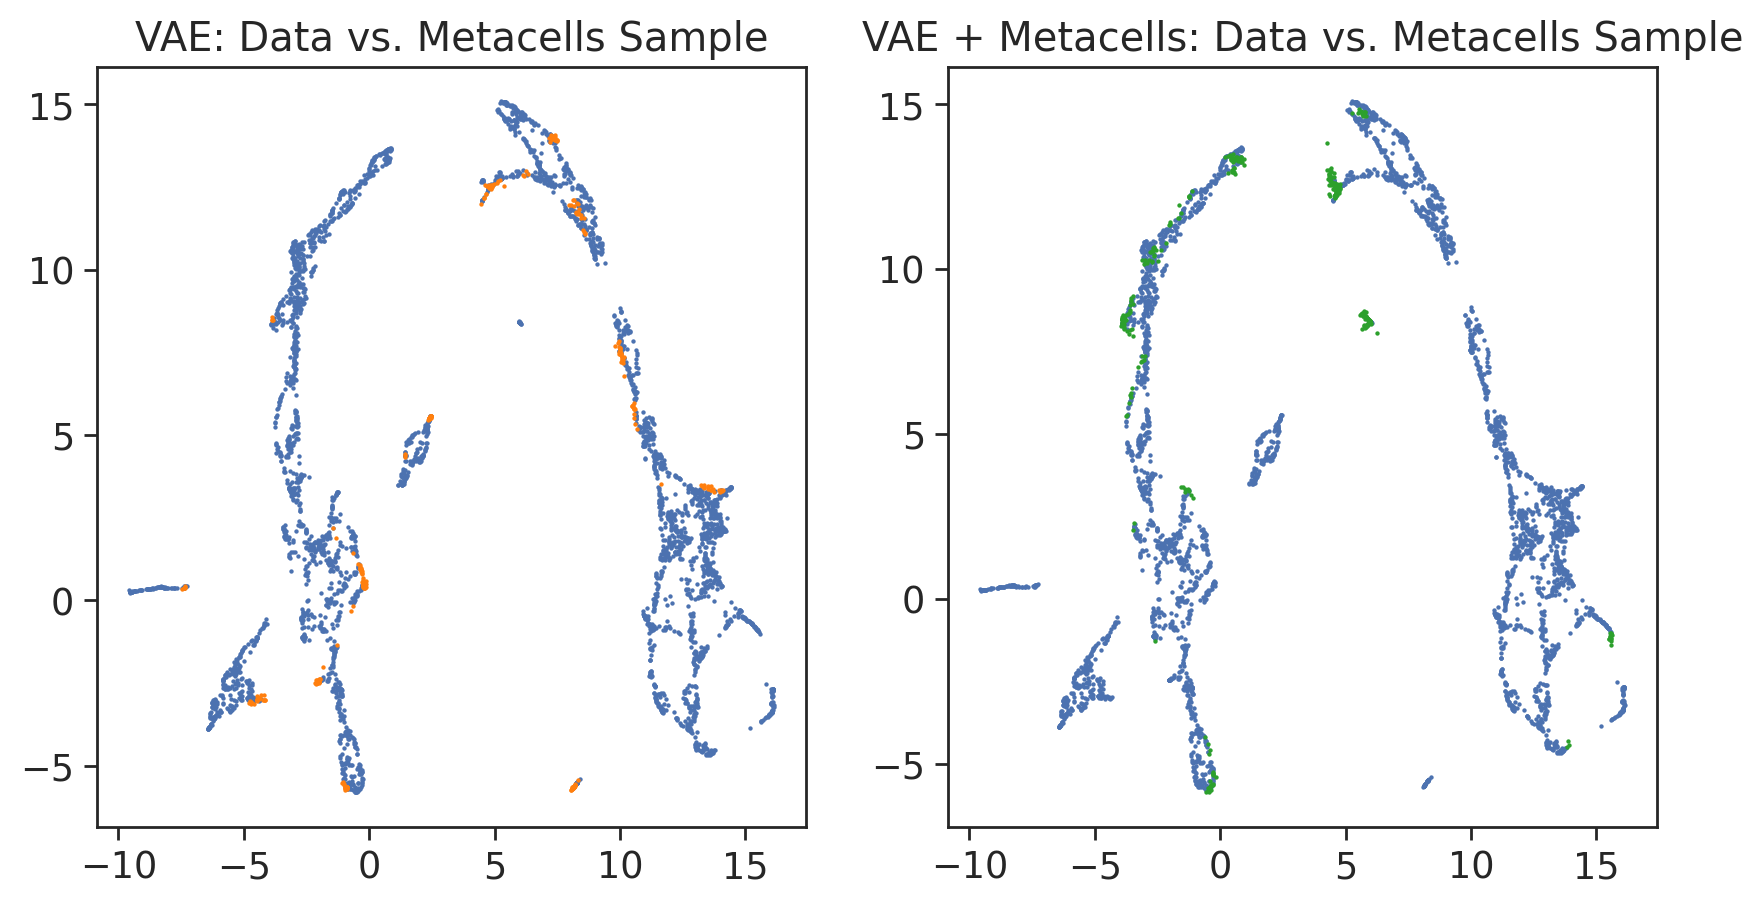

In [34]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_metaoriginal_2d.T, s=0.6, c='tab:orange')
ax.set_title('VAE: Data vs. Metacells Sample')


ax = plt.subplot(1,2,2)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_metameta_2d.T, s=0.6, c='tab:green')
ax.set_title('VAE + Metacells: Data vs. Metacells Sample')